In [1]:
import numpy as np
import os
import csv

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150


def read_csv(set_type, limit = None):
    # чтение подготовленного csv файла, содержащего множество set_type, необязательный аргумент limit 
    # определяет максимальное количество объектов каждого из класса в считываемом множестве
    path = os.path.join(os.getcwd(), 'csv files', str(img_size))
    class_ind = 0
    X = []
    Y = []
    for label in labels:
        filename = os.path.join(path, set_type + '_' + label + '.csv')
        print(filename)
        with open(filename, newline='') as csvfile:
            reader = csv.reader(csvfile)
            count = 1
            for row in reader:
                image = np.array([float(x) for x in row])
                image = image.reshape(img_size, img_size)
                X.append(image)
                Y.append(class_ind)
                if count % 200 == 0:
                    print(count, end = ' ')
                if count == limit:
                    break
                count += 1
            print('\n')
        class_ind += 1
        
    X = np.array(X) 
    X = X.reshape(-1, img_size, img_size, 1)
    Y = np.array(Y)        
    return X, Y
                                

In [3]:
x_train, y_train = read_csv('train')
print(x_train.shape)
print(y_train.shape)

/home/nikolay/Jupiter_Notebook/Pneumonia classification CNN/csv files/150/train_PNEUMONIA.csv
200 400 600 800 1000 1200 1400 1600 1800 2000 2200 2400 2600 2800 3000 3200 3400 3600 

/home/nikolay/Jupiter_Notebook/Pneumonia classification CNN/csv files/150/train_NORMAL.csv
200 400 600 800 1000 

(4751, 150, 150, 1)
(4751,)


In [4]:
x_val, y_val = read_csv('val')
print(x_val.shape)
print(y_val.shape)

/home/nikolay/Jupiter_Notebook/Pneumonia classification CNN/csv files/150/val_PNEUMONIA.csv
200 

/home/nikolay/Jupiter_Notebook/Pneumonia classification CNN/csv files/150/val_NORMAL.csv
200 

(400, 150, 150, 1)
(400,)


In [5]:
x_test, y_test = read_csv('test')
print(x_test.shape)
print(y_test.shape)

/home/nikolay/Jupiter_Notebook/Pneumonia classification CNN/csv files/150/test_PNEUMONIA.csv
200 

/home/nikolay/Jupiter_Notebook/Pneumonia classification CNN/csv files/150/test_NORMAL.csv
200 

(700, 150, 150, 1)
(700,)


In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf

from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout,  Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau, Callback


# для воспроизводимости результатов:
seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
# отключение GPU:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # если воспроизводимость не нужна,
                                            # эту строчку следует закомментировать для ускорения обучения

In [7]:
# класс, позволяющий замерять точноть на валидации после каждой эпохи для каждого из классов
class Metrics(Callback):
    def __init__(self, x_val, y_val):
        self.x_val = x_val
        self.y_val = y_val
        self.sen = []
        self.spe = []

    def on_epoch_end(self, batch, logs={}):        
        predictions = (model.predict(self.x_val) > 0.5).astype("int32")
        predictions = predictions.reshape(1,-1)[0]
        
        cm = confusion_matrix(predictions, self.y_val)
        self.sen.append(cm[0,0] / (cm[0,0] + cm[1,0]))
        self.spe.append(cm[1,1] / (cm[1,1] + cm[0,1]))
        print(cm) # выводит матрицу ошибок
        print(self.sen[-1]) # выводит значение sencitivity для текущей эпохи
        print(self.spe[-1]) # выводит значение specificity для текущей эпохи    
        return
    
    def get_data(self):
        return self.sen, self.spe


In [8]:
datagen = ImageDataGenerator(
        rotation_range = 20,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = False,
        vertical_flip=False)

model = Sequential()
model.add(Conv2D(32, (3,3), strides = 1, padding = 'same', activation = 'relu',
                 input_shape = (img_size,img_size,1)))
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))

model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [9]:
epoch = 40
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose=1, factor=0.3, min_lr=0.000001)
metrics = Metrics(x_val, y_val)
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32, seed = seed_value) ,epochs = epoch , validation_data = (x_val, y_val), callbacks = [reduce_lr, metrics])

Epoch 1/40
149/149 [==============================] - 16s 38ms/step - loss: 0.6023 - accuracy: 0.7749 - val_loss: 0.7708 - val_accuracy: 0.5375
[[199 184]
 [  1  16]]
0.995
0.08
Epoch 2/40
149/149 [==============================] - 5s 33ms/step - loss: 0.3937 - accuracy: 0.8075 - val_loss: 0.6406 - val_accuracy: 0.7175
[[200 113]
 [  0  87]]
1.0
0.435
Epoch 3/40
149/149 [==============================] - 5s 33ms/step - loss: 0.3235 - accuracy: 0.8559 - val_loss: 0.8246 - val_accuracy: 0.6800
[[200 128]
 [  0  72]]
1.0
0.36
Epoch 4/40
149/149 [==============================] - 5s 33ms/step - loss: 0.2667 - accuracy: 0.8875 - val_loss: 0.3333 - val_accuracy: 0.8475
[[198  59]
 [  2 141]]
0.99
0.705
Epoch 5/40
149/149 [==============================] - 5s 33ms/step - loss: 0.2408 - accuracy: 0.9109 - val_loss: 0.3826 - val_accuracy: 0.8225
[[200  71]
 [  0 129]]
1.0
0.645
Epoch 6/40
149/149 [==============================] - 5s 34ms/step - loss: 0.1957 - accuracy: 0.9254 - val_loss: 0.301

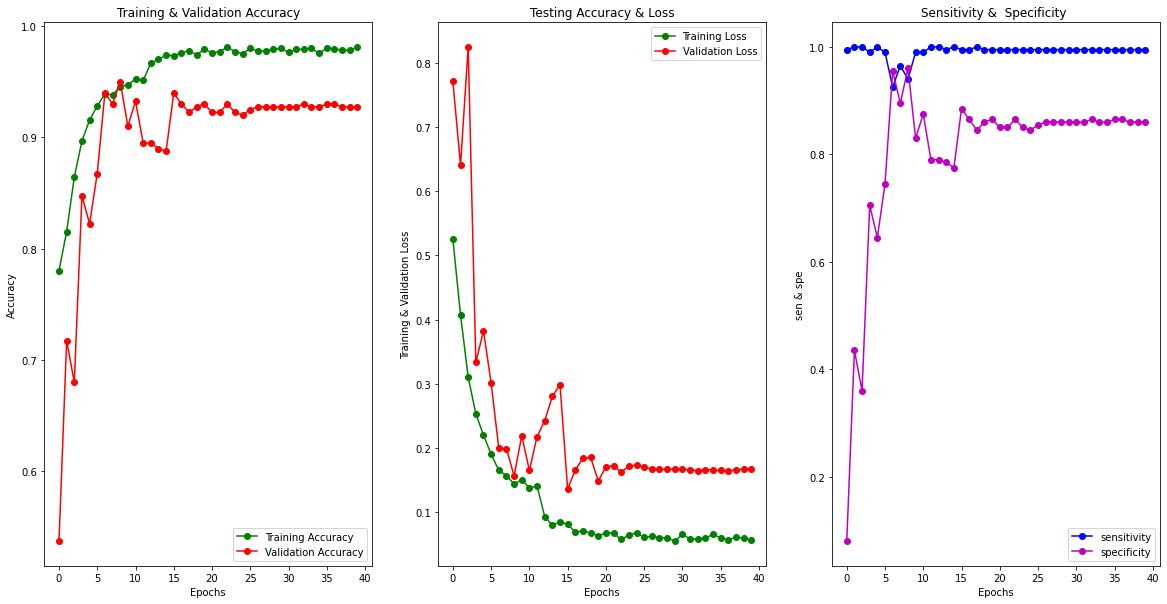

In [10]:
epochs = [i for i in range(epoch)]

fig , ax = plt.subplots(1,3)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc , 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc , 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")

sen, spe = metrics.get_data()
ax[2].plot(epochs, sen, 'b-o', label = 'sensitivity')
ax[2].plot(epochs, spe, 'm-o', label = 'specificity')
ax[2].set_title('Sensitivity &  Specificity ')
ax[2].legend()
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("sen & spe")

plt.show()

In [11]:
fig.savefig('history.png')

In [12]:
# заполнение и вывод матрицы ошибок для тестового множества:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
cm = confusion_matrix(predictions, y_test)
print(cm)

[[347  92]
 [  3 258]]


In [13]:
# нахождение эпохи (или нескольких эпох) с максимальной точностью на валидации
m = max(val_acc)
maxs = [i for i, j in enumerate(val_acc) if j == m]
print(maxs)
print(m)

[8]
0.949999988079071


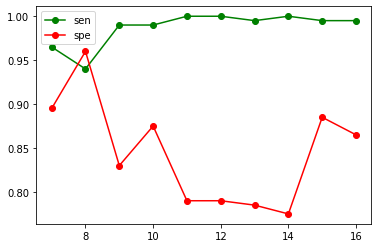

In [14]:
# более детальный график, позволяющий проанализировать поведение кривых в диапазоне эпох [left_b; right_b]
left_b = 7
right_b = 17

epochs = [i for i in range(left_b, right_b)]

plt.plot(epochs, sen[left_b : right_b], 'g-o', label = 'sen')
plt.plot(epochs, spe[left_b : right_b], 'r-o', label = 'spe')
plt.legend()

plt.show()